# ✈️ Predictive Maintenance on Aircraft Dataset

### 📋 Project Overview
This notebook aims to predict the Remaining Useful Life (RUL) of aircraft engines using a public dataset from NASA.

### 📊 Dataset Description
The dataset consists of multivariate time series data from different aircraft engines, divided into training and test sets. Each engine's operational data includes various sensor measurements and operational settings. The training set contains data until engine failure, while the test set ends before failure, with the ground truth data containing the true RUL values for evaluation.

The data is structured like this:

1. Unit number
2. Time, in cycles
3. Operational setting 1
4. Operational setting 2
5. Operational setting 3
6. Sensor measurements 1-26

The dataset is publicly available and can be downloaded here:  
🔗 [NASA CMAPSS Jet Engine Simulated Data](https://data.nasa.gov/Aerospace/CMAPSS-Jet-Engine-Simulated-Data/ff5v-kuh6/about_data)

### 🎯 Goals
1. **Predict Remaining Useful Life (RUL)**: Estimate how many operational cycles remain before an engine fails.
2. **Binary Classification**: Determine if an engine will fail within the next 15 cycles.

## Import Libraries

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

## Import Datasets

In [113]:
# Load the data
train_data = pd.read_csv("Kaggle_Dataset/PM_train.txt", sep=" ", header=None)
test_data = pd.read_csv("Kaggle_Dataset/PM_test.txt", sep=" ", header=None)
ground_truth = pd.read_csv("Kaggle_Dataset/PM_truth.txt", sep=" ", header=None)

## Exploratory Data Analysis (EDA)  

In [114]:
# What kind of data do we have?
# Are there any missing values?
print(train_data.info())
print(test_data.info())
print(ground_truth.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20631 non-null  int64  
 1   1       20631 non-null  int64  
 2   2       20631 non-null  float64
 3   3       20631 non-null  float64
 4   4       20631 non-null  float64
 5   5       20631 non-null  float64
 6   6       20631 non-null  float64
 7   7       20631 non-null  float64
 8   8       20631 non-null  float64
 9   9       20631 non-null  float64
 10  10      20631 non-null  float64
 11  11      20631 non-null  float64
 12  12      20631 non-null  float64
 13  13      20631 non-null  float64
 14  14      20631 non-null  float64
 15  15      20631 non-null  float64
 16  16      20631 non-null  float64
 17  17      20631 non-null  float64
 18  18      20631 non-null  float64
 19  19      20631 non-null  float64
 20  20      20631 non-null  float64
 21  21      20631 non-null  int64  
 22

### Data Overview and Missing Values

The provided datasets include `train_data`, `test_data`, and `ground_truth`. Below is a summary of the structure and the presence of missing values in these datasets:

1. **train_data**:
    - Number of entries: 20,631
    - Number of columns: 28
    - Data types: 24 float64 and 4 int64
    - Missing values: Columns 26 and 27 contain only missing values (Non-Null Count: 0)

2. **test_data**:
    - Number of entries: 13,096
    - Number of columns: 28
    - Data types: 24 float64 and 4 int64
    - Missing values: Columns 26 and 27 contain only missing values (Non-Null Count: 0)

3. **ground_truth**:
    - Number of entries: 100
    - Number of columns: 2
    - Data types: 1 float64 and 1 int64
    - Missing values: Column 1 contains only missing values (Non-Null Count: 0)

**Observations**:
- Both `train_data` and `test_data` have identical structure with two columns (26 and 27) containing only missing values.
- The `ground_truth` dataset has one column (1) with only missing values.
- For further analysis, it would be prudent to consider dropping these columns with only missing values, as they do not provide any useful information.

## Preprocessing  
- Drop Empty Columns: Remove columns with no data to clean up the dataset.
- Label Columns: Assign meaningful names to columns based on the dataset documentation.
- Sort Data: Organize data by engine ID and operational cycle for consistency.
- Normalize Data: Scale sensor measurements and settings between 0 and 1 to ensure uniformity in model training.

### Drop Empty Columns 

In [115]:
# Drop empty columns
train_data.dropna(axis=1, inplace=True)
test_data.dropna(axis=1, inplace=True)
ground_truth.dropna(axis=1, inplace=True)

### Label Columns  

In [116]:
# Add column names
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# Add column names to the dataframes
train_data.columns = cols_names
test_data.columns = cols_names

# Label ground truth data with column name 'RUL' (remaining useful life)
ground_truth.columns = ['RUL']

### Sort columns by the attributes 'id' and 'cycle'  

In [117]:
train_data = train_data.sort_values(['id', 'cycle'])
test_data = test_data.sort_values(['id', 'cycle'])

### Normalize training data in all columns that are different to 'id' and 'cycle'  

In [118]:
# Function to normalize data
def normalize_data(data, norm_cols):
    min_max_scaler = MinMaxScaler()
    norm_data = pd.DataFrame(min_max_scaler.fit_transform(data[norm_cols]), columns=norm_cols, index=data.index)
    return data[['id', 'cycle']].join(norm_data)

# Identify columns to normalize
norm_cols = train_data.columns.difference(['id', 'cycle'])

# Normalize train data
train_data = normalize_data(train_data, norm_cols)

# Normalize test data
test_data = normalize_data(test_data, norm_cols)

## Feature Engineering  
- Preparing train and test data by adding RUL (remaining useful life) and RUL in less than 15 cycles binary features
- Dynamic Sensor Data: Plot sensor measurements over time for individual engines to understand trends and anomalies.
- Correlation Heatmap: Visualize the correlation between sensor measurements and the target variable (RUL).

### Preparing train and test data  

In [119]:
# Helper function to find the maximum cycle for each engine
def get_max_cycle(df):
    df_max_cycle = pd.DataFrame(df.groupby('id')['cycle'].max())
    df_max_cycle.reset_index(level=0, inplace=True)
    df_max_cycle.columns = ['id', 'last_cycle']
    return df_max_cycle

# Helper function to calculate Remaining Useful Life (RUL)
def calculate_RUL(df):
    df['RUL'] = df['last_cycle'] - df['cycle']
    df.drop(['last_cycle'], axis=1, inplace=True)
    return df

# Helper function to create binary classification label based on RUL
def create_binary_label(df, period):
    df['label_bnc'] = df['RUL'].apply(lambda x: 1 if x <= period else 0)
    return df

# Method to prepare training data
def prepare_train_data(df_train, period):
    df_max_cycle = get_max_cycle(df_train)
    df_train = pd.merge(df_train, df_max_cycle, on='id')
    df_train = calculate_RUL(df_train)
    df_train = create_binary_label(df_train, period)
    return df_train

# Method to prepare testing data
def prepare_test_data(df_test, df_truth, period):
    df_test_last_cycle = get_max_cycle(df_test)
    df_test = pd.merge(df_test, df_test_last_cycle, on='id')
    df_test = df_test[df_test['cycle'] == df_test['last_cycle']]
    df_test.drop(['last_cycle'], axis=1, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    df_test = pd.concat([df_test, df_truth], axis=1)
    df_test = create_binary_label(df_test, period)
    return df_test

In [120]:
# Prepare data by calculating RUL and creating binary labels for failure within 15 cycles
train_data = prepare_train_data(train_data, 15)
test_data = prepare_test_data(test_data, ground_truth, 15)

### Plotting dynamic sensor data

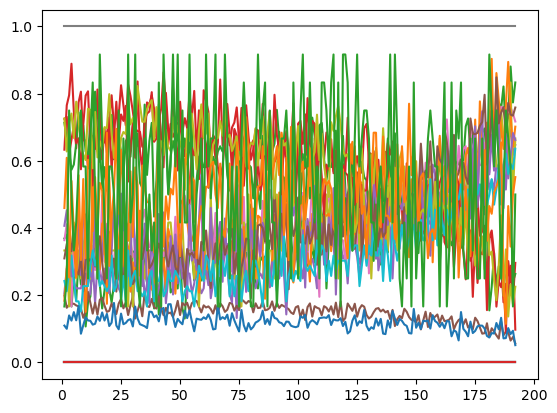

In [121]:
# Plot dynamic sensor data
for i in train_data.columns.difference(['id', 'cycle', 'label_bnc', 'RUL']):
   plt.plot(train_data[train_data["id"] == 1]["cycle"], train_data[i][train_data["id"] == 1], label=i)
    #print(i)
plt.show()

### Plotting correlation heatmap and identifying features with high correlation to target variable

Features with low correlation to target variable: ['s6']
Features with high correlation to target variable: ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']


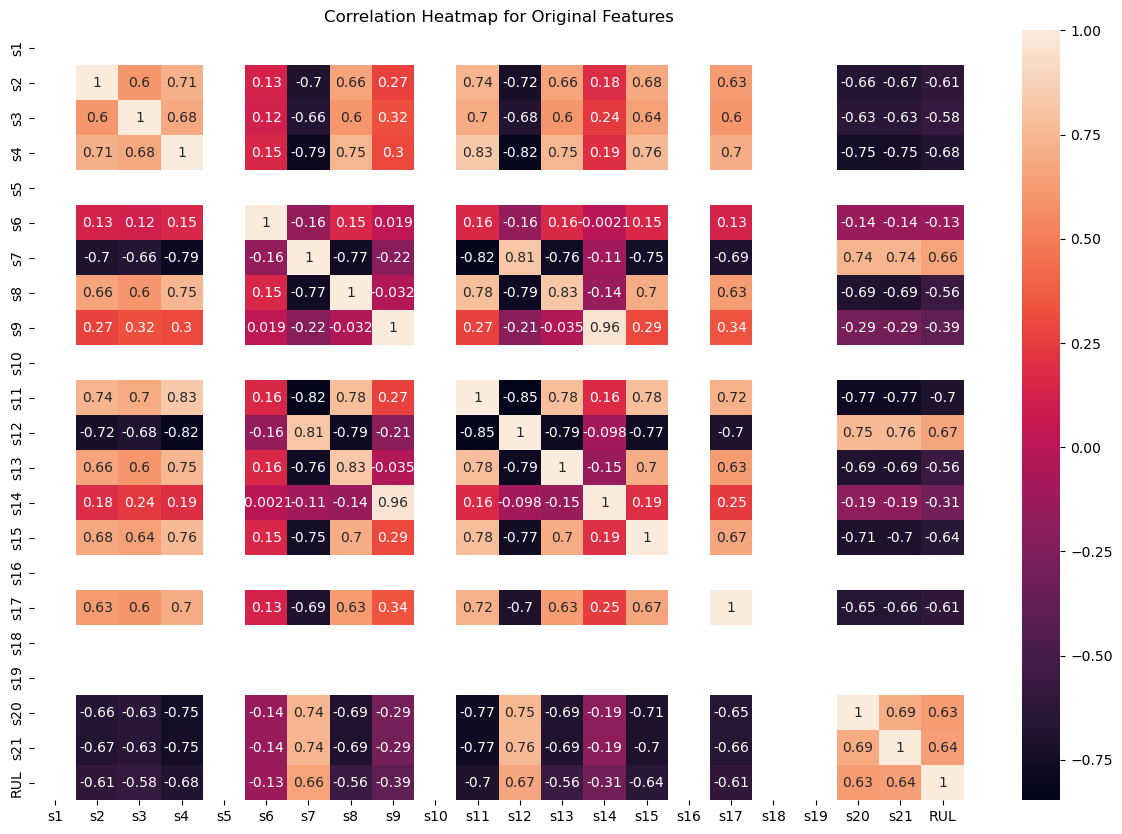

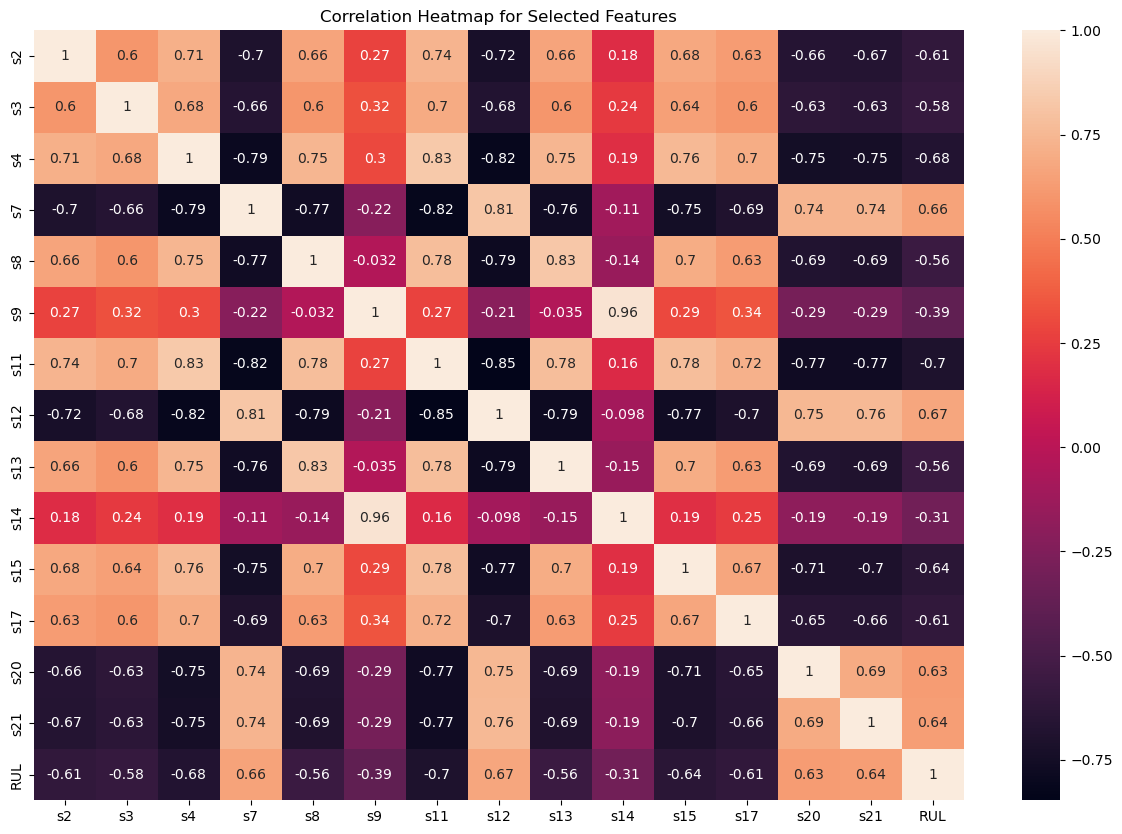

In [122]:
# Original features in the dataset
features_orig = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
settings = ['setting1', 'setting2', 'setting3']

# Create a heatmap to visualize correlations between original features and target variable
plt.figure(figsize=(15, 10))
corr_orig = train_data[features_orig + ['RUL']].corr()
sns.heatmap(corr_orig, annot=True)
plt.title("Correlation Heatmap for Original Features")

# Determine features with low and high correlation to the target variable 'RUL'
correlation_with_target = corr_orig['RUL']
high_corr_threshold = 0.3
low_corr_threshold = 0.3

features_high_corr = correlation_with_target[abs(correlation_with_target) > high_corr_threshold].index.tolist()
features_low_corr = correlation_with_target[abs(correlation_with_target) < low_corr_threshold].index.tolist()

# Remove the target variable from the lists
if 'RUL' in features_high_corr:
    features_high_corr.remove('RUL')
if 'RUL' in features_low_corr:
    features_low_corr.remove('RUL')

# Choose features to use
features = features_high_corr

# Create a heatmap to visualize correlations between selected features and target variable
plt.figure(figsize=(15, 10))
corr_selected = train_data[features + ['RUL']].corr()
sns.heatmap(corr_selected, annot=True)
plt.title("Correlation Heatmap for Selected Features")

# Display features with low and high correlation
print("Features with low correlation to target variable:", features_low_corr)
print("Features with high correlation to target variable:", features_high_corr)

### Feature Correlation Analysis and Frequency Features

In the previous analysis, we explored the correlation between the original features and the target variable (remaining useful life, `RUL`) using a heatmap. This allowed us to identify features with high and low correlations to the target variable.

**Results:**

- **Features with low correlation to target variable**:
  - `s6`

- **Features with high correlation to target variable**:
  - `s2`, `s3`, `s4`, `s7`, `s8`, `s9`, `s11`, `s12`, `s13`, `s14`, `s15`, `s17`, `s20`, `s21`

We selected the features with high correlation to the target variable to be used in our predictive model, as they are more likely to have a significant impact on the model's performance.

**Adding Frequency Features:**

To further enhance our feature set, we are incorporating frequency features derived from the original time-series data. The frequency domain analysis, particularly using Fast Fourier Transform (FFT), can uncover patterns that are not apparent in the time domain. Here’s why this is beneficial:

1. **Capture Periodic Patterns**: The FFT can identify periodic components within the data, which might correlate with the target variable but are not directly observable in the time domain.

2. **Additional Insights**: Frequency features provide a different perspective on the data, revealing underlying structures and patterns that time-domain features might miss.

3. **Improved Model Performance**: By combining both time-domain and frequency-domain features, we enhance the richness of the data representation, potentially leading to better predictive performance.

By integrating these frequency features with the high-correlation features identified earlier, we aim to build a more robust and comprehensive model.

In [123]:
def create_frequency_features(data):
    # Apply FFT to the data
    fft_data = np.fft.fft(data)
    
    # Calculate the magnitude of the FFT coefficients
    magnitude = np.abs(fft_data)
    
    # Calculate the power spectrum density (PSD)
    psd = np.square(magnitude)
    
    # Calculate the frequency bins
    frequency_bins = np.fft.fftfreq(len(data))
    
    # Select the positive frequency bins
    positive_bins = frequency_bins[:len(data)//2]
    
    # Select the corresponding magnitude and PSD values
    positive_magnitude = magnitude[:len(data)//2]
    positive_psd = psd[:len(data)//2]
    
    # Return the frequency domain features
    return positive_bins, positive_magnitude, positive_psd

In [124]:
# Create frequency domain features for training data
train_data_freq = pd.DataFrame()

# Loop through each sensor feature
for i in features:
    bins, magnitude, psd = create_frequency_features(train_data[i])
    train_data_freq[i + '_freq'] = magnitude
    
# Create frequency domain features for test data
test_data_freq = pd.DataFrame()
for i in features:
    bins, magnitude, psd = create_frequency_features(test_data[i])
    test_data_freq[i + '_freq'] = magnitude
    
# Add frequency domain features back to the training and test data
train_data = pd.concat([train_data, train_data_freq], axis=1)
test_data = pd.concat([test_data, test_data_freq], axis=1)
freq_features = train_data_freq.columns.difference(['id', 'cycle', 'RUL', 'label_bnc'])

features = features + list(freq_features) + settings
print(features)

['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21', 's11_freq', 's12_freq', 's13_freq', 's14_freq', 's15_freq', 's17_freq', 's20_freq', 's21_freq', 's2_freq', 's3_freq', 's4_freq', 's7_freq', 's8_freq', 's9_freq', 'setting1', 'setting2', 'setting3']


In [125]:
# Prepare training and testing data for regression model
X_train_reg = train_data[features]
y_train_reg = train_data['RUL']
X_test_reg = test_data[features]
y_test_reg = test_data['RUL']

# Prepare training and testing data for classification model
X_train_bnc = train_data[features]
y_train_bnc = train_data['label_bnc']
X_test_bnc = test_data[features]
y_test_bnc = test_data['label_bnc']

## Model Training 🚀

In this section, we explore two different approaches for predicting the Remaining Useful Life (RUL) of aircraft engines: regression and classification models.

### Regression Model 📈

A regression model aims to predict the exact number of remaining operational cycles before an engine fails. By training the model on historical data, where the target variable is the RUL, we can estimate how many cycles are left before maintenance is required. This continuous prediction is critical for scheduling timely maintenance and avoiding unexpected failures.

### Classification Model 📊

In addition to the regression approach, we also employ a classification model to predict whether an engine will fail within the next 15 cycles. This binary classification provides a straightforward "yes" or "no" answer, helping maintenance teams quickly identify engines that need immediate attention. By using the classification model, we aim to enhance the decision-making process with clear and actionable predictions.

By leveraging both regression and classification models, we can gain comprehensive insights into the condition of aircraft engines, enabling more effective and efficient maintenance strategies.

### Regression model  

In [126]:
# Training the model	
model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Define the parameter grid
param_grid = {
    'n_estimators': [49, 99, 149, 199],
    'max_depth': [1, 2, 3],
    'max_features': [1, 2, 3]
}

# Implement GridSearchCV for cross-validation and hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_reg, y_train_reg)

# Display the best parameters
print("Best Parameters: ", grid_search.best_params_)

# best params n_estimators=99, max_depth=3, max_features=3: r2=0.663, RMSE = 25.134, MAE = 18.908
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters:  {'max_depth': 3, 'max_features': 3, 'n_estimators': 99}


**Optimized Model Parameters**

After conducting hyperparameter tuning using GridSearchCV, the best parameters for the RandomForestRegressor model are:

- `max_depth`: 3
- `max_features`: 3
- `n_estimators`: 99

These parameters were determined through 5-fold cross-validation, optimizing for negative mean absolute error. The resulting model achieves an R^2 score of approximately 0.663, with an RMSE of around 24.134 and an MAE of approximately 18.908.

These optimized parameters provide valuable insights for enhancing model performance, guiding further evaluation and visualization efforts.

In [127]:
# Evaluate the best model
y_pred = best_model.predict(X_test_reg)

# Calculate the evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
mae = mean_absolute_error(y_test_reg, y_pred)
r2 = r2_score(y_test_reg, y_pred)

# Display the evaluation metrics
print("RMSE: ", rmse) # 0 means perfect prediction
print("MAE: ", mae) # 0 means perfect prediction
print("R2: ", r2) # 1 means perfect prediction

RMSE:  24.133662790769066
MAE:  18.908153246753685
R2:  0.6627228369191562


### Model Performance Evaluation for Aircraft Data RUL Prediction

In this section, we evaluate the performance of our model in predicting the Remaining Useful Life (RUL) of aircraft engines based on the last cycle of machine data. The evaluation metrics used are Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared ($R^2$). Each metric provides a different perspective on the model's predictive accuracy and overall performance.

**1. Root Mean Squared Error (RMSE): 24.13**

**Scientific Evaluation:**
RMSE measures the standard deviation of the residuals (prediction errors). It provides an indication of how well the model's predictions match the actual data points. The formula for RMSE is:

$$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)^2} $$

where $\hat{y}_i$ are the predicted values, $y_i$ are the actual values, and $n$ is the number of observations.

- An RMSE of 24.13 means that the typical deviation between the predicted RUL and the actual RUL is approximately 24 cycles.
- This metric is sensitive to outliers, meaning larger errors have a more significant impact on RMSE.
- To interpret RMSE effectively, it is crucial to consider the scale of the target variable. In the context of our dataset, if the RUL values range widely, an RMSE of 24.13 might be reasonable. However, if the RUL values are generally low, this indicates substantial prediction errors.

**2. Mean Absolute Error (MAE): 18.91**

**Scientific Evaluation:**
MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. The formula for MAE is:

$$ \text{MAE} = \frac{1}{n} \sum_{i=1}^n |\hat{y}_i - y_i| $$

- An MAE of 18.91 indicates that, on average, the predicted RUL is off by about 19 cycles.
- Unlike RMSE, MAE is less sensitive to outliers and provides a more direct interpretation of the average prediction error.
- Lower MAE values indicate better model performance. In our case, the MAE value suggests that while the model performs reasonably well.

**3. R-squared ($R^2$): 0.66**

**Scientific Evaluation:**
$R^2$, also known as the coefficient of determination, measures the proportion of the variance in the dependent variable that is predictable from the independent variables. The formula for $R^2$ is:

$$ R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y}_i)^2} $$

where $\bar{y}$ is the mean of the actual values.

- An $R^2$ value of 0.66 indicates that approximately 66% of the variance in the RUL can be explained by the model's features.
- This is a decent $R^2$ value, suggesting that the model captures a significant portion of the variance in RUL. However, 34% of the variance remains unexplained.
- Higher $R^2$ values generally indicate better model fit, but it is essential to balance high $R^2$ with other considerations like overfitting.

### Overall Model Assessment:

- The RMSE and MAE values are relatively close, which suggests that there are no extreme outliers heavily influencing the error metrics.
- An $R^2$ value of 0.66 implies that the model is capturing a substantial portion of the variance in the RUL data, but there is still unexplained variance.

### Conclusion:

While the current model shows a reasonable performance with an $R^2$ of 0.66, there is still room for improvement. Future work should focus on refining feature engineering, tuning hyperparameters, and exploring different modeling techniques to enhance predictive accuracy.

Number of times prediction was too low: 53
Number of times prediction was too high: 47
Mean difference when prediction was too low: 24.135889517163466
Mean difference when prediction was too high: 13.013046388632015
Total mean absolute difference: 18.908153246753685


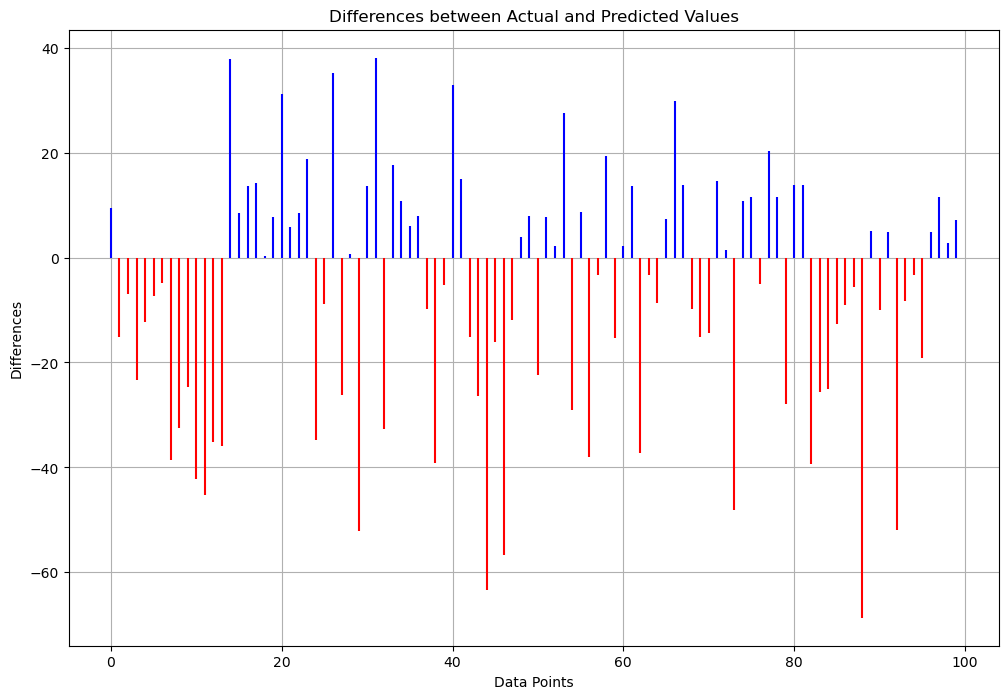

In [128]:
import numpy as np
import matplotlib.pyplot as plt

# Data visualization: Differences between Actual and Predicted values
plt.figure(figsize=(12, 8))

# Initialize counters and lists for differences
too_high_count = 0
too_low_count = 0
too_high_diffs = []
too_low_diffs = []

# Plot vertical lines between actual and predicted values
for i in range(len(y_test_reg)):
    diff = y_pred[i] - y_test_reg[i]
    if diff >= 0:
        too_high_count += 1
        too_high_diffs.append(diff)
        plt.vlines(x=i, ymin=0, ymax=diff, colors='blue')
    else:
        too_low_count += 1
        too_low_diffs.append(-diff)
        plt.vlines(x=i, ymin=0, ymax=diff, colors='red')

# Calculate means
mean_too_low = np.mean(too_low_diffs) if too_low_diffs else 0
mean_too_high = np.mean(too_high_diffs) if too_high_diffs else 0

# Calculate the total mean absolute difference
total_mean_absolute_difference = np.mean(np.abs(y_test_reg - y_pred))

# Print the results
print("Number of times prediction was too low:", too_low_count)
print("Number of times prediction was too high:", too_high_count)
print("Mean difference when prediction was too low:", mean_too_low)
print("Mean difference when prediction was too high:", mean_too_high)
print("Total mean absolute difference:", total_mean_absolute_difference)

plt.xlabel('Data Points')
plt.ylabel('Differences')
plt.title('Differences between Actual and Predicted Values')
plt.grid(True)
plt.show()

### 📈 Evaluation of the Regression Model

The regression model was trained and evaluated to predict the Remaining Useful Life (RUL) of aircraft engines based on the given dataset. Here are the detailed evaluation metrics:

- **📉 Number of times prediction was too low**: 53
- **📈 Number of times prediction was too high**: 47
- **📏 Mean difference when prediction was too low**: 24.136 cycles
- **📏 Mean difference when prediction was too high**: 13.013 cycles
- **📊 Total mean absolute difference (MAD)**: 18.908 cycles

#### 📝 Evaluation:

- **📉 Number of times prediction was too low**: The model underestimated the RUL in 53 instances. This could lead to unnecessary maintenance actions and increasing costs.
  
- **📈 Number of times prediction was too high**: The model overestimated the RUL in 47 instances. Overestimating RUL is more critical, as it can result in unexpected failures, posing higher risks and potential safety issues.
  
- **📏 Mean difference when prediction was too low**: The mean difference of 24.136 cycles suggests significant underestimation. This considerable margin may prompt a review of features or model adjustments.
  
- **📏 Mean difference when prediction was too high**: The mean difference of 13.013 cycles indicates that overestimations are less severe compared to underestimations. However, reducing these errors further could enhance model reliability.
  
- **📊 Total mean absolute difference (MAD)**: The MAD of 18.908 cycles represents substantial average error, indicating the model's predictions need improvement for better precision.

#### 🏁 Conclusion

The regression model provides valuable insights into predicting the RUL of aircraft engines. While the model demonstrates reasonable accuracy, particularly in avoiding overestimations, there is significant room for improvement. Enhancing the model to reduce both overestimation and underestimation errors, especially minimizing the more substantial underestimations, is crucial for improving the reliability and safety of predictive maintenance decisions.

### Classification Model  

Instead of predicting the Remaining Useful Life (RUL) of the engines, we aim to predict whether there will be an engine failure within the next 15 cycles. To achieve this, we implement a RandomForestClassifier, leveraging its robustness and effectiveness in handling imbalanced datasets. The following steps outline the training, hyperparameter tuning, and evaluation of the classification model.


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Classifier:  {'max_depth': 3, 'max_features': 3, 'n_estimators': 249}
Accuracy:  0.9
Precision:  0.5
Recall:  1.0
F1 Score:  0.6666666666666666
Confusion Matrix: 
 [[80 10]
 [ 0 10]]


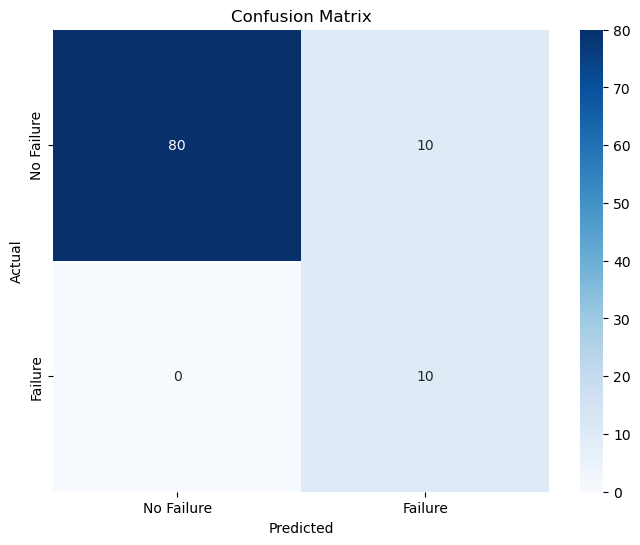

In [129]:
# Train a RandomForestClassifier
classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define the parameter grid for GridSearchCV
param_grid_class = {
    'n_estimators': [49, 149, 249],
    'max_depth': [1, 2, 3],
    'max_features': [1, 2, 3]
}

# Implement GridSearchCV for cross-validation and hyperparameter tuning
grid_search_class = GridSearchCV(estimator=classifier, param_grid=param_grid_class, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the classifier model
grid_search_class.fit(X_train_bnc, y_train_bnc)

# Display the best parameters
print("Best Parameters for Classifier: ", grid_search_class.best_params_)

# Train the best classifier model
best_classifier = grid_search_class.best_estimator_

# Predict the test set labels
y_pred_class = best_classifier.predict(X_test_bnc)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_bnc, y_pred_class)
precision = precision_score(y_test_bnc, y_pred_class)
recall = recall_score(y_test_bnc, y_pred_class)
f1 = f1_score(y_test_bnc, y_pred_class)
conf_matrix = confusion_matrix(y_test_bnc, y_pred_class)

# Display the evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix: \n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### 🛠️ Evaluation of the Classification Model

The RandomForestClassifier was trained and evaluated to predict whether an engine will experience failure within the next 15 cycles based on the given dataset. Here are the detailed evaluation metrics:

- **🔧 Best Parameters for Classifier**: {'max_depth': 3, 'max_features': 3, 'n_estimators': 249}
- **📊 Accuracy**: 0.9
- **🎯 Precision**: 0.5
- **📈 Recall**: 1.0
- **⚖️ F1 Score**: 0.6667
- **🔍 Confusion Matrix**:
  ```
  [[80 10]
   [ 0 10]]
  ```

#### 📚 Definitions of Evaluation Metrics:

- **📊 Accuracy**: Measures the proportion of correctly predicted instances among all instances.
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$
  where \( TP \) is True Positive, \( TN \) is True Negative, \( FP \) is False Positive, and \( FN \) is False Negative.

- **🎯 Precision**: Indicates how many of the predicted positive instances are actually positive.
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

- **📈 Recall (Sensitivity)**: Measures the proportion of actual positive instances that are correctly predicted.
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

- **⚖️ F1 Score**: Harmonic mean of precision and recall, providing a single metric that balances both concerns.
  $$
  \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

#### 📝 Evaluation:

- **📊 Accuracy**: The model achieves an accuracy of 0.9, indicating that 90% of the predictions are correct. This metric is high, suggesting overall good performance.

- **🎯 Precision**: The precision of 0.5 means that when the model predicts engine failure within 15 cycles, it is correct 50% of the time. This could imply that there are some false positives.

- **📈 Recall**: The recall of 1.0 indicates that the model identifies all instances of actual engine failures within 15 cycles. This is a desirable outcome as it minimizes false negatives.

- **⚖️ F1 Score**: The F1 score of 0.6667 balances precision and recall, reflecting moderate performance in correctly identifying engine failures while minimizing false positives.

#### 📊 Confusion Matrix

The confusion matrix shows:
- 80 True Negatives (TN): Correctly predicted no engine failure.
- 10 False Positives (FP): Predicted engine failure incorrectly.
- 0 False Negatives (FN): Failed to predict engine failure when it occurred.
- 10 True Positives (TP): Correctly predicted engine failure.

#### 🏁 Conclusion  
The RandomForestClassifier demonstrates strong performance in predicting engine failures within the next 15 cycles, achieving high accuracy and recall. However, the precision indicates potential for improvement to reduce false positives. Future refinements could focus on feature engineering, hyperparameter tuning, and exploring alternative models to further enhance predictive accuracy and reliability.

**Disclaimer:**

Alle Markdown-Zellen in diesem Jupyter Notebook wurden mithilfe von ChatGPT auf grammatikalische und inhaltliche Richtigkeit überprüft und durch Formatierungen ausgeschmückt. Trotz größter Sorgfalt und mehrmaliger Überprüfung kann keine Garantie für absolute Fehlerfreiheit übernommen werden.